<H3>PRI 2023/24: second
    project delivery</H3>

**GROUP 08**
- Daniele Avolio    , ist1111559
- Michele Vitale	, ist1111558	
- Luís Dias	        , ist198557

<H2>Main facilities</H2>

<h3>Part I: clustering</h3>

*A) Clustering*

This function takes a document, along with optional inverted index and clustering arguments, and returns the best clustering solution for the given task, determined by proper internal indices.

In [123]:
# Imports useful later

import os
import sys
import time
import random
import nltk
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import cluster 
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer



In [124]:
import os  


def read_files(location:str, skip_first_line:bool=True) -> list:
    """
    Read all text files in the specified location and return their contents as a list.
    """
    files_list = []
    
    for root, dirs, files in os.walk(location):
        for file in files:
            if file.endswith(".txt"): 
                with open(os.path.join(root, file), "r") as auto:
                    if skip_first_line: auto.readline()
                    # Skip the first line
                    files_list.append(auto.read().strip())
    return files_list

In [125]:

categories_ranges = {
    'business': [0, 509],
    'entertainment': [510, 895],
    'politics': [896, 1311],
    'sport': [1312, 1823],
    'tech': [1824, 2224]
}

We will get those from the beginning, so we won't have problems in the future.

In [4]:
documents = read_files("../BBC News Summary/News Articles")
summaries = read_files("../BBC News Summary/Summaries", skip_first_line=False)

In [5]:
print(documents[0])
print()
print(summaries[0])


Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-spe

In [126]:
# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestCentroid
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import math



def sentence_clustering(d: str, I=None, alpha=1, beta=0.45, gamma=0.05, **kwargs):
    # Workflow idea:
    # 1. Split the document into sentences using nltk
    # 2. Convert the sentences into vectors using TfIdf
    # 3. Cluster the vectors using Hierarchical Clustering
    # 4. Return the clusters

    # Problems: How many clusters should we use?
    # Answer: We can use the elbow method to find the optimal number of clusters

    # Problems: How do we know if the clusters are good?
    # Answer: We can use the silhouette score to evaluate the quality of the clusters

    sentences = nltk.sent_tokenize(d)

    # Convert each sentene in array of words s
    word_sentenes = [nltk.word_tokenize(sentence) for sentence in sentences]

    # remove words sentences with less than 10 words
    words_sentences = [s for s in word_sentenes if len(s) > 5]
    
    # Join sequences again
    sentences = [" ".join(s) for s in words_sentences]

    # Remove all sentences of len 1
    # (Time 23:14 - Wasted estimated time: 2h)
    # Problem: Literally a dot '.'
    sentences = [s for s in sentences if len(s) > 1]

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # Parameter for the score functoin
    # Best number of clusters
    best_score = 0
    best_n_clusters = 2

    max_clusters = kwargs.get("max_clusters", len(sentences))

    if max_clusters > len(sentences):
        max_clusters = len(sentences)

    linkage = kwargs.get("linkage", "complete")
    metric = "cosine"

    if linkage == "ward":
        metric = "euclidean"

    
    for n_clusters in range(2, max_clusters):
        model = AgglomerativeClustering(
            n_clusters=n_clusters, linkage=linkage, metric=metric
        )
        labels = model.fit_predict(X.toarray())
        # Calculate the silhouette score, which measures the compactness and separation of the clusters.
        # A higher silhouette score indicates better clustering quality.
        # It ranges from -1 to 1, with 1 being the best score.
        # The goal is to maximize the silhouette score.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

        silhouette_score_value = silhouette_score(X.toarray(), labels) * alpha

        # # Calculate the Calinski-Harabasz score, which measures the ratio of between-cluster dispersion to within-cluster dispersion.
        # # A higher Calinski-Harabasz score indicates better clustering quality.
        # # It is based on the analysis of variance (ANOVA) and measures the separation between clusters.
        # # The goal is to maximize the Calinski-Harabasz score.
        # # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html
        # c_score = calinski_harabasz_score(X.toarray(), labels) * beta

        # # clusters score based on the number of clusters
        # # the more, the worse. We are going to subtract this value from the final score

        # cluster_score = math.log(n_clusters)
        # final_score = math.log(silhouette_score_value) + math.log(c_score) - cluster_score * gamma
        # print(f"Numero di cluster: {n_clusters}, Silhouette score: {silhouette_score_value}, Calinski-Harabasz score: {c_score}, Final score: {final_score}")

        if silhouette_score_value > best_score:
            best_score = silhouette_score_value
            best_n_clusters = n_clusters

    # print(f"Numero ottimale di cluster: {best_n_clusters}")

    model = AgglomerativeClustering(
        n_clusters=best_n_clusters, linkage=linkage, metric=metric
    )

    labels = model.fit_predict(X.toarray())

    # 5. Costruisci la soluzione di clustering
    cluster_solution = {}
    for i, label in enumerate(labels):
        if label not in cluster_solution:
            cluster_solution[label] = []
        cluster_solution[label].append(sentences[i])

    if kwargs.get("return_centroids", False):
        ncentroid = NearestCentroid()
        ncentroid.fit(X.toarray(), labels)
        centroids = ncentroid.centroids_
        return cluster_solution, centroids

    return cluster_solution

In [7]:
doc = documents[0]
sentence_clustering(doc, None, linkage="ward")

{3: ['Quarterly profits at US media giant TimeWarner jumped 76 % to $ 1.13bn ( Â£600m ) for the three months to December , from $ 639m year-earlier .',
  'But its film division saw profits slump 27 % to $ 284m , helped by box-office flops Alexander and Catwoman , a sharp contrast to year-earlier , when the third and final film in the Lord of the Rings trilogy boosted results .',
  'For the full-year , TimeWarner posted a profit of $ 3.36bn , up 27 % from its 2003 performance , while revenues grew 6.4 % to $ 42.09bn .'],
 4: ['The firm , which is now one of the biggest investors in Google , benefited from sales of high-speed internet connections and higher advert sales .',
  'TimeWarner said fourth quarter sales rose 2 % to $ 11.1bn from $ 10.9bn .'],
 1: ['Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros , and less users for AOL .',
  'For 2005 , TimeWarner is projecting operating earnings growth of around 5 % , and also expects higher revenue and wider

We will create a functio to visualize the clusters, and another to visualize the dendrogram.

In [127]:

from sklearn.decomposition import PCA

def plot_clusters(clusters:dict, return_plot:bool=False):
    # Get the vector space from the clusters
    values = clusters.values()

    # Convert the sentences into vectors using TfIdf
    vectorizer = TfidfVectorizer(stop_words="english")
    sentences = [sentence for cluster in values for sentence in cluster]
    
    X = vectorizer.fit_transform(sentences)

    # Reduce the dimensionality of the vectors to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())

    # Plot the clusters and set the color 
    # knowing that the keys of the clusters are the labels and the 
    # values are the sentences

    for key, value in clusters.items():
        plt.scatter(X_pca[[sentences.index(sentence) for sentence in value], 0], 
                    X_pca[[sentences.index(sentence) for sentence in value], 1], 
                    label=f"Cluster {key}", s=151)  # Set the size of the circles to 100

    if return_plot: return plt
    
    # Plot the confidence ellipses
    plt.legend()
    plt.show()




In [9]:
for i, doc in enumerate(documents):
    print(f"Documento {i}")
    clusters = sentence_clustering(doc)
    print("\n")

Documento 0


Documento 1


Documento 2




Documento 3


Documento 4


Documento 5


Documento 6


Documento 7


Documento 8


Documento 9


Documento 10


Documento 11


Documento 12


Documento 13


Documento 14


Documento 15


Documento 16


Documento 17


Documento 18


Documento 19


Documento 20


Documento 21


Documento 22


Documento 23


Documento 24


Documento 25


Documento 26


Documento 27


Documento 28


Documento 29


Documento 30


Documento 31


Documento 32


Documento 33


Documento 34


Documento 35


Documento 36


Documento 37


Documento 38


Documento 39


Documento 40


Documento 41


Documento 42


Documento 43


Documento 44


Documento 45


Documento 46


Documento 47


Documento 48


Documento 49


Documento 50


Documento 51


Documento 52


Documento 53


Documento 54


Documento 55


Documento 56


Documento 57


Documento 58


Documento 59


Documento 60


Documento 61


Documento 62


Documento 63


Documento 64


Documento 65


Documento 66


Documento 67


Documento 68


Documento 69




KeyboardInterrupt: 

The way we are selecting the best clustering solution is by using the silhouette score, which is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Other than that we are using the Calinski-Harabasz index, which is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters.

The number of cluster is determined usign minimum 2 or maximum the number of sentences in the document. Not sure if this is the best approach, but we will see.

Documento 0


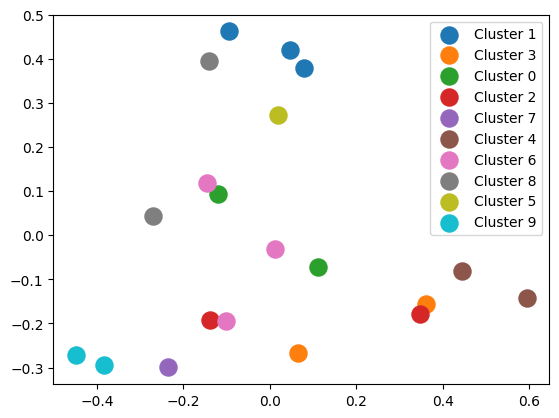



Documento 1


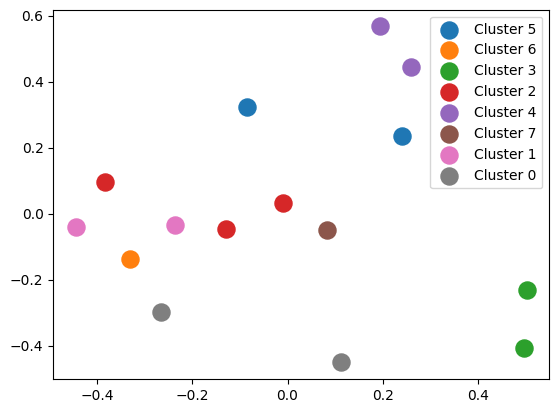



Documento 2


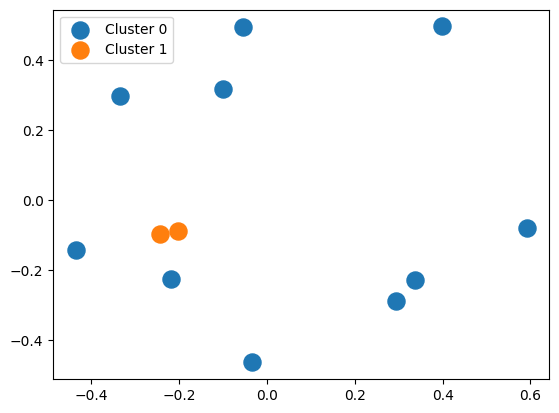



Documento 3


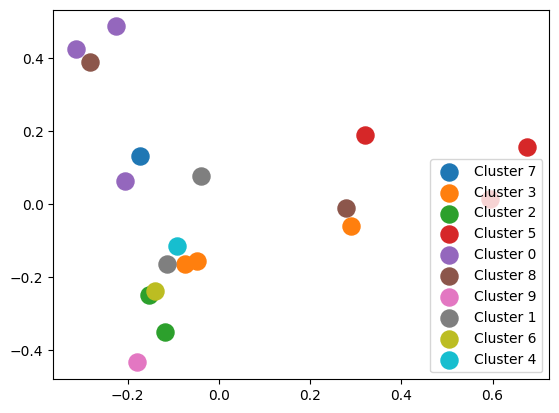



Documento 4


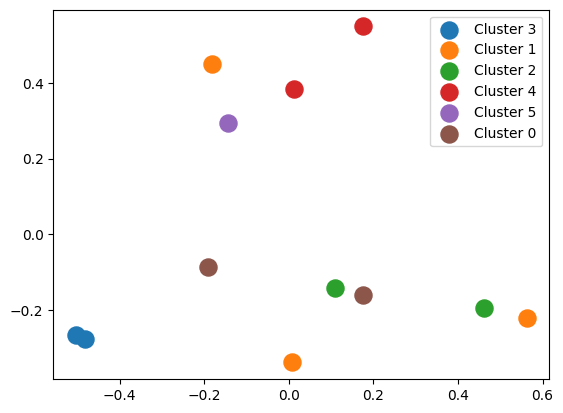



Documento 5


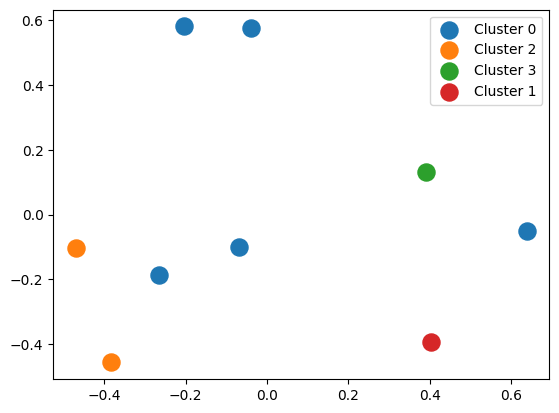



Documento 6


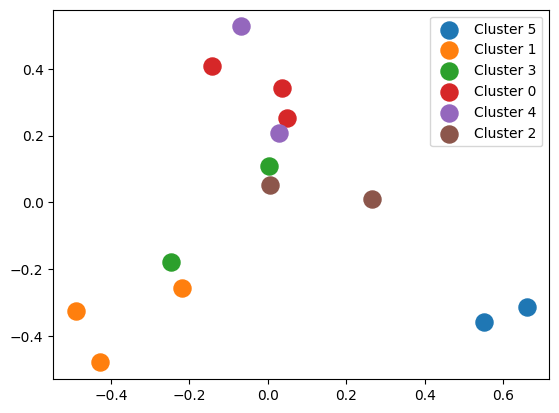



Documento 7


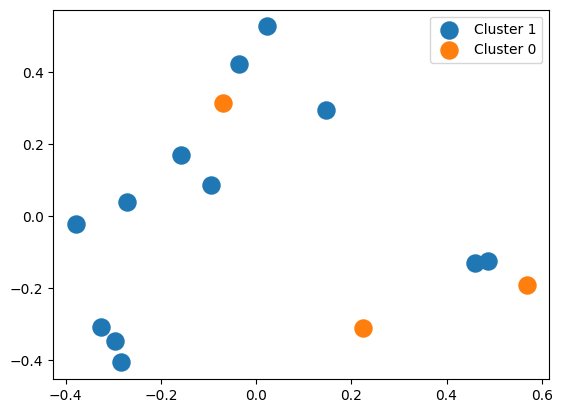



Documento 8


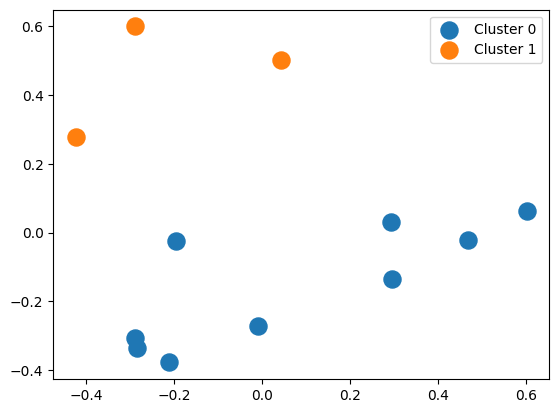



Documento 9


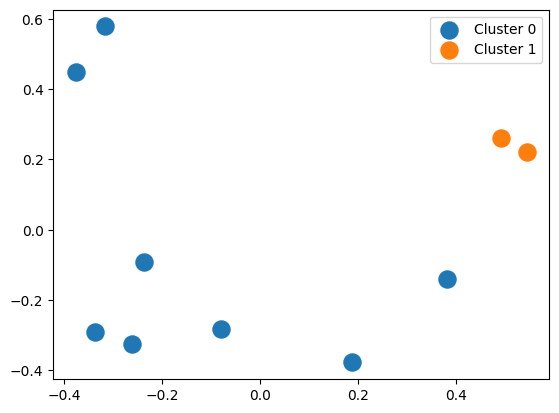

In [ ]:
docs = documents[0:10]
for i, doc in enumerate(docs):
    print(f"Documento {i}")
    clusters = sentence_clustering(doc)
    plot_clusters(clusters)
    print("\n")

*B) Summarization*

In [129]:
# Summarizatio part
from sklearn.metrics.pairwise import cosine_similarity

def summarization(doc:str, clusters:dict, I=None, centroids=None, **kwargs):
    number_of_sentences = kwargs.get("number_of_sentences", 1)

    sentences = nltk.sent_tokenize(doc)

    # Convert each sentene in array of words s
    word_sentenes = [nltk.word_tokenize(sentence) for sentence in sentences]

    # remove words sentences with less than 10 words
    words_sentences = [s for s in word_sentenes if len(s) > 5]
    
    # Join sequences again
    sentences = [" ".join(s) for s in words_sentences]

    # Remove all sentences of len 1
    # (Time 23:14 - Wasted estimated time: 2h)
    # Problem: Literally a dot '.'
    sentences = [s for s in sentences if len(s) > 1]


    
    # We keep 1 at the beginning to see how it goes
    final_summary = ""        
    vectorizer = TfidfVectorizer()

    # We fit the vectorizer with all the sentences in the document
    vectorizer.fit(sentences)


    # For each cluster
    for k in clusters.keys():
        # We take the phrases
        phrases = clusters[k]
        distances = []

        # We transform the phrases into vectors using tfidf
        X = vectorizer.transform(phrases)

        centroid = centroids[k]

        # For each phrase vector
        for phrase in X.toarray():
            distances.append(cosine_similarity(phrase.reshape(1, -1), centroid.reshape(1, -1)))


        # Sort the sentences by their distance to the centroid
        sorted_indices = np.argsort(distances, axis=0).flatten()

        # Add the top sentences to the final summary
        final_summary += " ".join([phrases[i] for i in sorted_indices[:number_of_sentences]])

    # print(f"\n - Number of clusters: {len(clusters.keys())} \n - Number of sentences per cluster: {number_of_sentences} \n - Summary: {final_summary}")
    return final_summary

In [ ]:
# Try with doc 0
doc = documents[43]

clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=5)
summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=2)

print(summary)

A recession is commonly defined as two consecutive quarters of negative growth , although the Japanese government takes other factors into account when judging the status of its economy . On Wednesday , the government revised growth figures from earlier in 2004 which , when taking into account performance in the most recent period , effectively tips Japan into recession .A previous estimate of 0.1 % growth between July and September was downgraded to a 0.3 % decline . Ministers pointed to the fact that consumer spending had been depressed by one-off factors such as the unseasonably mild winter .The Tokyo stock market fell after the figures were announced , but rose again on a widespread perception that the economy will recover later this year . Analysts said the figures were disappointing but argued that Japan 's largest companies had been recording healthy profits and capital spending was on the rise .However , politicians remain upbeat about prospects for an economic boost later in t

Known problem:

- What if we have only 1 phrase per cluster and we set the 2 sentence for cluster?
- I don't like this at all to be honest

In [ ]:
# Let's test the time to summarize all the documents
import time

start = time.time()

for i,doc in enumerate(documents):

    print(f"Summarizing document {i} of {len(documents)}")
    clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=5)
    summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=2)

end = time.time()

print(f"Time to summarize all the documents: {end - start} seconds")

Summarizing document 0 of 2225
Summarizing document 1 of 2225
Summarizing document 2 of 2225
Summarizing document 3 of 2225
Summarizing document 4 of 2225
Summarizing document 5 of 2225
Summarizing document 6 of 2225
Summarizing document 7 of 2225
Summarizing document 8 of 2225
Summarizing document 9 of 2225
Summarizing document 10 of 2225
Summarizing document 11 of 2225
Summarizing document 12 of 2225
Summarizing document 13 of 2225
Summarizing document 14 of 2225
Summarizing document 15 of 2225
Summarizing document 16 of 2225
Summarizing document 17 of 2225
Summarizing document 18 of 2225
Summarizing document 19 of 2225
Summarizing document 20 of 2225
Summarizing document 21 of 2225
Summarizing document 22 of 2225
Summarizing document 23 of 2225
Summarizing document 24 of 2225
Summarizing document 25 of 2225
Summarizing document 26 of 2225
Summarizing document 27 of 2225
Summarizing document 28 of 2225
Summarizing document 29 of 2225
Summarizing document 30 of 2225
Summarizing docume

*C) Keyword extraction*

In [137]:


def keyword_extraction(doc:str, C:dict, I=None, **kwargs):
    # doc words

    words = nltk.word_tokenize(doc)

    # Stopwords
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    # Punctuation
    words = [word for word in words if word.isalpha()]
    # Digits
    words = [word for word in words if not word.isdigit()]

    # In this case we need lemmatization
    lemmatizer = nltk.WordNetLemmatizer()

    words = [lemmatizer.lemmatize(word) for word in words]


    cluster_keywords = []

    # Vectorizer

    # For each cluster
    for k in C.keys():
        keywords = []
        phrases = C[k]
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(phrases)
        
        # For each keyword get the tfidf score
        for word in set(words):
            if word in vectorizer.vocabulary_:
                tfidf = X.toarray()[:, vectorizer.vocabulary_[word]]
                keywords.append((word, np.mean(tfidf)))
        
        # Sort the keywords by their tfidf score
        keywords = sorted(keywords, key=lambda x: x[1], reverse=True)

        
        cluster_keywords.append(keywords[:3])


    keywords = []
    # take only the first element of the pair
    for k in cluster_keywords:
        for word, _ in k:
            keywords.append(word)
    
    return list(set(keywords))

In [ ]:
doc = documents[0]
clusters = sentence_clustering(doc)

keyword_extraction(doc, clusters, None)

['stake',
 'quarter',
 'profit',
 'expects',
 'market',
 'said',
 'internet',
 'earnings',
 'film',
 'posted',
 'fourth',
 'loss',
 'chief',
 'restate',
 'set',
 'mixed',
 'owns',
 'business',
 'better',
 'sale',
 'exceeding',
 'deal',
 'inquiry',
 'settle']

In [143]:
# Extraction test over all the documents

extractions = {}
for i, doc in enumerate(documents):
    clusters = sentence_clustering(doc)
    keywords = keyword_extraction(doc, clusters, None)
    category = None
    for k, v in categories_ranges.items():
        if v[0] <= i <= v[1]:
            category = k
            break

    extractions[i] = {
        "index" : i,
        "keywords": keywords,
        "category": category
    }

# We will use this to build our dataset



*D) Evaluation*

In [ ]:
# Using the project 1 evaluation functions

import nltk
def precision(summary, relevant_summary):
    summary_words = set(nltk.word_tokenize(summary))
    relevant_summary_words = set(nltk.word_tokenize(relevant_summary))

    retrieved_and_relevant = len(summary_words.intersection(relevant_summary_words))

    if len(summary_words) == 0:
        return 0
    return retrieved_and_relevant / len(summary_words)

def recall(summary, relevant_summary):
    summary_words = set(nltk.word_tokenize(summary))
    relevant_summary_words = set(nltk.word_tokenize(relevant_summary))

    retrieved_and_relevant = len(summary_words.intersection(relevant_summary_words))

    if len(relevant_summary_words) == 0:
        return 0
    return retrieved_and_relevant / len(relevant_summary_words)

def accuracy(summary, relevant_summary):
    summary_words = set(nltk.word_tokenize(summary))
    relevant_summary_words = set(nltk.word_tokenize(relevant_summary))

    retrieved_and_relevant = len(summary_words.intersection(relevant_summary_words))
    retrieved = len(summary_words)

    if len(relevant_summary_words) == 0:
        return 0
    
    return retrieved_and_relevant / retrieved

# Lecture
def f1_score(precision, recall, alpha=0.5):
    if precision == 0 or recall == 0:
        return 0
    
    return 1 / (alpha / precision + (1 - alpha) / recall)

# Lab
def alternative_f1_score(precision, recall):
    if precision == 0 or recall == 0:
        return 0
    
    return 2 * (precision * recall) / (precision + recall)

# Net
def mean_average_precision(precision_list, recall_list):
    # Sort by recall
    sorted_indices = np.argsort(recall_list)
    sorted_precision = np.array(precision_list)[sorted_indices]
    sorted_recall = np.array(recall_list)[sorted_indices]
    
    # Compute the precision envelope
    for i in range(sorted_precision.size - 1, 0, -1):
        sorted_precision[i - 1] = np.maximum(sorted_precision[i - 1], sorted_precision[i])
    
    # Calculate the average precision
    recall_change = np.diff(sorted_recall)
    precision_change = sorted_precision[:-1]
    ap = np.sum(recall_change * precision_change)
    
    return ap

    

In [ ]:
from sklearn.metrics import auc


def plot_pr_curve(precision, recall, name):
    pairs = sorted(zip(recall, precision))

    recall = []
    precision = []
    for pair in pairs:
        recall.append(pair[0])
        precision.append(pair[1])
        
    
    # We will get the best precision at that point
        # and we will do it in reverse 
    precision = list(precision)
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])
    
    
    area = auc(recall, precision)
    
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve for {name} (area = {area:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for {name}')
    plt.legend(loc="lower left")
    plt.show()

In [ ]:

def evaluation_given_summaries(produced_summaries:list, real_summaries:list, name):

    initial_time = time.time()

    # We need to compare the produced summaries with the real summaries
    # evaluation statistics, including F-measuring at predefined p-or-l summary
    # limits, recall-and-precision curves, MAP, and efficiency

    # Calculate precision and recall for each document
    precisions = []
    recalls = []


    for i, key in enumerate(produced_summaries):
        precision_value = precision(produced_summaries[i], real_summaries[i])
        recall_value = recall(produced_summaries[i], real_summaries[i])
        precisions.append(precision_value)
        recalls.append(recall_value)

    
    # Calculate the average precision and recall
    average_precision = sum(precisions) / len(precisions)
    average_recall = sum(recalls) / len(recalls)

    # Calculate the F1 score
    f1 = alternative_f1_score(average_precision, average_recall)

    # Calculate standard deviation
    std_precision = np.std(precisions)
    std_recall = np.std(recalls)
    
    m_a_p = mean_average_precision(precisions, recalls)

    plot_pr_curve(precisions, recalls, name)


    end_time = time.time() - initial_time

    print()
    print(f"""####### Time to process {len(produced_summaries)} documents: \n 
        - {end_time} seconds \n
        - {end_time / len(produced_summaries)} seconds per document
        \n""")
    print()

    return average_precision, average_recall, f1, std_precision, std_recall, m_a_p

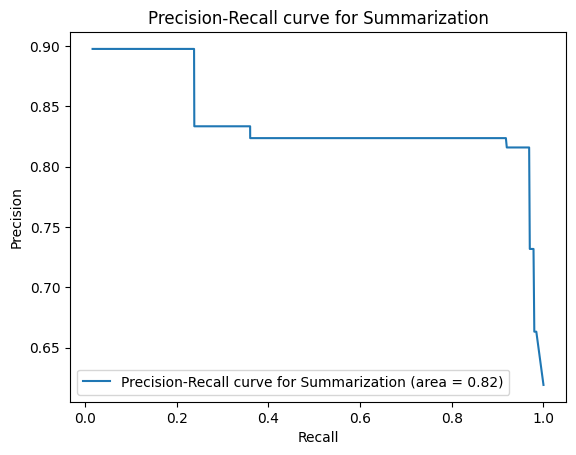


####### Time to process 2225 documents: 
 
        - 6.919574975967407 seconds 

        - 0.0031099213375134415 seconds per document
        


Average precision: 0.4620238084049586
Average recall: 0.43600661901932874
F1 score: 0.44863833664714864
Standard deviation of precision: 0.11930955676913914
Standard deviation of recall: 0.21074743796444367
Mean average precision: 0.8227708484952972


In [ ]:
docs_to_summarize = documents
real_summaries = summaries

produced_summaries = []

for i, doc in enumerate(docs_to_summarize):
    clusters, centroids = sentence_clustering(doc, return_centroids=True, max_clusters=5)
    summary = summarization(doc, clusters, centroids=centroids, number_of_sentences=2)
    produced_summaries.append(summary)

average_precision, average_recall, f1, std_precision, std_recall, m_a_p = evaluation_given_summaries(produced_summaries, real_summaries, "Summarization")

print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"F1 score: {f1}")
print(f"Standard deviation of precision: {std_precision}")
print(f"Standard deviation of recall: {std_recall}")
print(f"Mean average precision: {m_a_p}")

<h3>Part II: classification</h3>

### The challenge here

The challenge is to build a nice `features` set for the sentences.

The goal is the following: *Take a sentence and a groundh truth summary. If the sentence is in the summary, the target variable will be $1$, otherwise $0$.*

The features will be used to `train` a model, and then `predict` the sentences that are in the summary.

- Number of words
- Number of stopwords
- Number of keywords
- General length of the sentence
- TF-IDF Score
- BM25 Score
- Cosine Similarity
- Position of the sentence in the document
- Category

*A) Feature extraction*

In [120]:
def get_similarity(sentence: str, doc: str):
    vectorizer = TfidfVectorizer()

    X = vectorizer.fit_transform(nltk.sent_tokenize(doc))

    sentence_vector = vectorizer.transform([sentence])
    doc_vector = vectorizer.transform([doc])

    similarity = cosine_similarity(sentence_vector, doc_vector).flatten()

    return similarity[0]

In [144]:
def feature_extraction(sentence: str, doc: str, doc_index=None, **kwargs):
    # cosine similarity between doc and sentence
    doc_tokenized = nltk.sent_tokenize(doc)
    words = nltk.word_tokenize(sentence)
    similarity = get_similarity(sentence, doc)

    # Numerical
    n_sentence = len(doc_tokenized)
    n_words = len(words)
    n_stopwords = len([word for word in words if word in ENGLISH_STOP_WORDS])

    if doc_index is None:
        n_keywords = len(keyword_extraction(doc, sentence_clustering(doc)))
    else:
        n_keywords = len(
            [word for word in words if word in extractions[doc_index]["keywords"]]
        )
    length_of_sentence = len(sentence)

    # TFIDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(doc_tokenized)
    sentence_vector = vectorizer.transform([sentence])
    tfidf_score = np.mean(sentence_vector.toarray())

    position_in_doc = doc_tokenized.index(sentence)

    if doc_index is None:
        category = "New"
    else:
        category = extractions[doc_index]["category"]

    # Tags
    pos_tags = nltk.pos_tag(words)
    n_nouns = len(
        [word for word, pos in pos_tags if pos in ["NN", "NNS", "NNP", "NNPS"]]
    )
    n_verbs = len(
        [
            word
            for word, pos in pos_tags
            if pos in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
        ]
    )
    n_adjectives = len([word for word, pos in pos_tags if pos in ["JJ", "JJR", "JJS"]])
    n_adverbs = len([word for word, pos in pos_tags if pos in ["RB", "RBR", "RBS"]])

    return [
        similarity,
        n_sentence,
        n_words,
        n_stopwords,
        n_keywords,
        length_of_sentence,
        tfidf_score,
        position_in_doc,
        category,
        n_nouns,
        n_verbs,
        n_adjectives,
        n_adverbs,
    ]

In [ ]:
# Dataset creation

features_list = []
count = 0
for i, doc in enumerate(documents):
    for sentence in nltk.sent_tokenize(doc):
        features = feature_extraction(sentence, doc, doc_index=i)
        features.append(count)
        if sentence in summaries[i]:
            features.append(1)
        else:
            features.append(0)
        count += 1
        features_list.append(features)

# Create the dataframe
columns = [
    "similarity",
    "n_sentence",
    "n_words",
    "n_stopwords",
    "n_keywords",
    "length_of_sentence",
    "tfidf_score",
    "position_in_doc",
    "category",
    "n_nouns",
    "n_verbs",
    "n_adjectives",
    "n_adverbs",
    "id",
    "summary"
]

In [54]:
try:
    df = pd.read_csv("dataset.csv")
    exists = True
except:
    df = pd.DataFrame(features_list, columns=columns)

In [55]:
# Print the first 5 rows
df.head()

,similarity,n_sentence,n_words,n_stopwords,n_keywords,length_of_sentence,tfidf_score,position_in_doc,n_nouns,n_verbs,n_adjectives,n_adverbs,id,summary,category_business,category_entertainment,category_politics,category_sport,category_tech
0,0.359330,20,28,7,0,136,0.019886,0,8,1,3,0,0,1,True,False,False,False,False
1,0.405842,20,26,10,1,143,0.019617,1,8,2,3,1,1,0,True,False,False,False,False
2,0.280236,20,15,2,3,69,0.015022,2,4,2,1,0,2,1,True,False,False,False,False
3,0.332313,20,22,8,1,106,0.019389,3,9,3,1,0,3,1,True,False,False,False,False
4,0.278403,20,15,5,2,71,0.015667,4,5,2,1,1,4,0,True,False,False,False,False


In [56]:
# one hot encoding
if not exists:
    df = pd.get_dummies(df, columns=["category"])

In [57]:
# save the dataset as csv
if not exists:
    df.to_csv("dataset.csv", index=False)

*B) Classification*

In [82]:
# Model creation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the dataset into training and testing
X = df.drop(columns=["id", "summary"])
y = df["summary"]

# Since we have 5 different categories, our dataset should be balanced.
# We need to extract the 80% and 20% for each of the categories. So, let's do it manually

# take all the documents for each category in the dataset
categories = {
    "business": df[df["category_business"] == 1],
    "entertainment": df[df["category_entertainment"] == 1],
    "politics": df[df["category_politics"] == 1],
    "sport": df[df["category_sport"] == 1],
    "tech": df[df["category_tech"] == 1]
}

# Split the dataset into training and testing
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for category, data in categories.items():
    X_train_category, X_test_category, y_train_category, y_test_category = train_test_split(
        data.drop(columns=["id", "summary"]), data["summary"], test_size=0.2
    )

    X_train = pd.concat([X_train, X_train_category])
    X_test = pd.concat([X_test, X_test_category])
    y_train = pd.concat([y_train, y_train_category])
    y_test = pd.concat([y_test, y_test_category])




In [83]:
y_train.shape, y_test.shape

((33120, 1), (8283, 1))

In [84]:
# Train each model
models = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "GaussianNB": GaussianNB(),
    "KNeighbors": KNeighborsClassifier(),
    "MLP": MLPClassifier()
}

for name, model in models.items():
    print(f"Training {name} model")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification report: \n {classification_report(y_test, y_pred)}")
    print("\n")

Training RandomForest model


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7366896052155016
Confusion matrix: 
 [[3980  834]
 [1347 2122]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.75      0.83      0.78      4814
         1.0       0.72      0.61      0.66      3469

    accuracy                           0.74      8283
   macro avg       0.73      0.72      0.72      8283
weighted avg       0.73      0.74      0.73      8283



Training GradientBoosting model


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7085597005915731
Confusion matrix: 
 [[3896  918]
 [1496 1973]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.72      0.81      0.76      4814
         1.0       0.68      0.57      0.62      3469

    accuracy                           0.71      8283
   macro avg       0.70      0.69      0.69      8283
weighted avg       0.71      0.71      0.70      8283



Training GaussianNB model
Accuracy: 0.6035252927683207
Confusion matrix: 
 [[2785 2029]
 [1255 2214]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.69      0.58      0.63      4814
         1.0       0.52      0.64      0.57      3469

    accuracy                           0.60      8283
   macro avg       0.61      0.61      0.60      8283
weighted avg       0.62      0.60      0.61      8283



Training KNeighbors model


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.59447060243873
Confusion matrix: 
 [[3309 1505]
 [1854 1615]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.64      0.69      0.66      4814
         1.0       0.52      0.47      0.49      3469

    accuracy                           0.59      8283
   macro avg       0.58      0.58      0.58      8283
weighted avg       0.59      0.59      0.59      8283



Training MLP model


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6883979234576845
Confusion matrix: 
 [[3061 1753]
 [ 828 2641]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.79      0.64      0.70      4814
         1.0       0.60      0.76      0.67      3469

    accuracy                           0.69      8283
   macro avg       0.69      0.70      0.69      8283
weighted avg       0.71      0.69      0.69      8283





Now we just try to remove some features from the dataset. We will check the matrix of correlation and remove the features that are highly correlated. Plus, let's try with Shap.

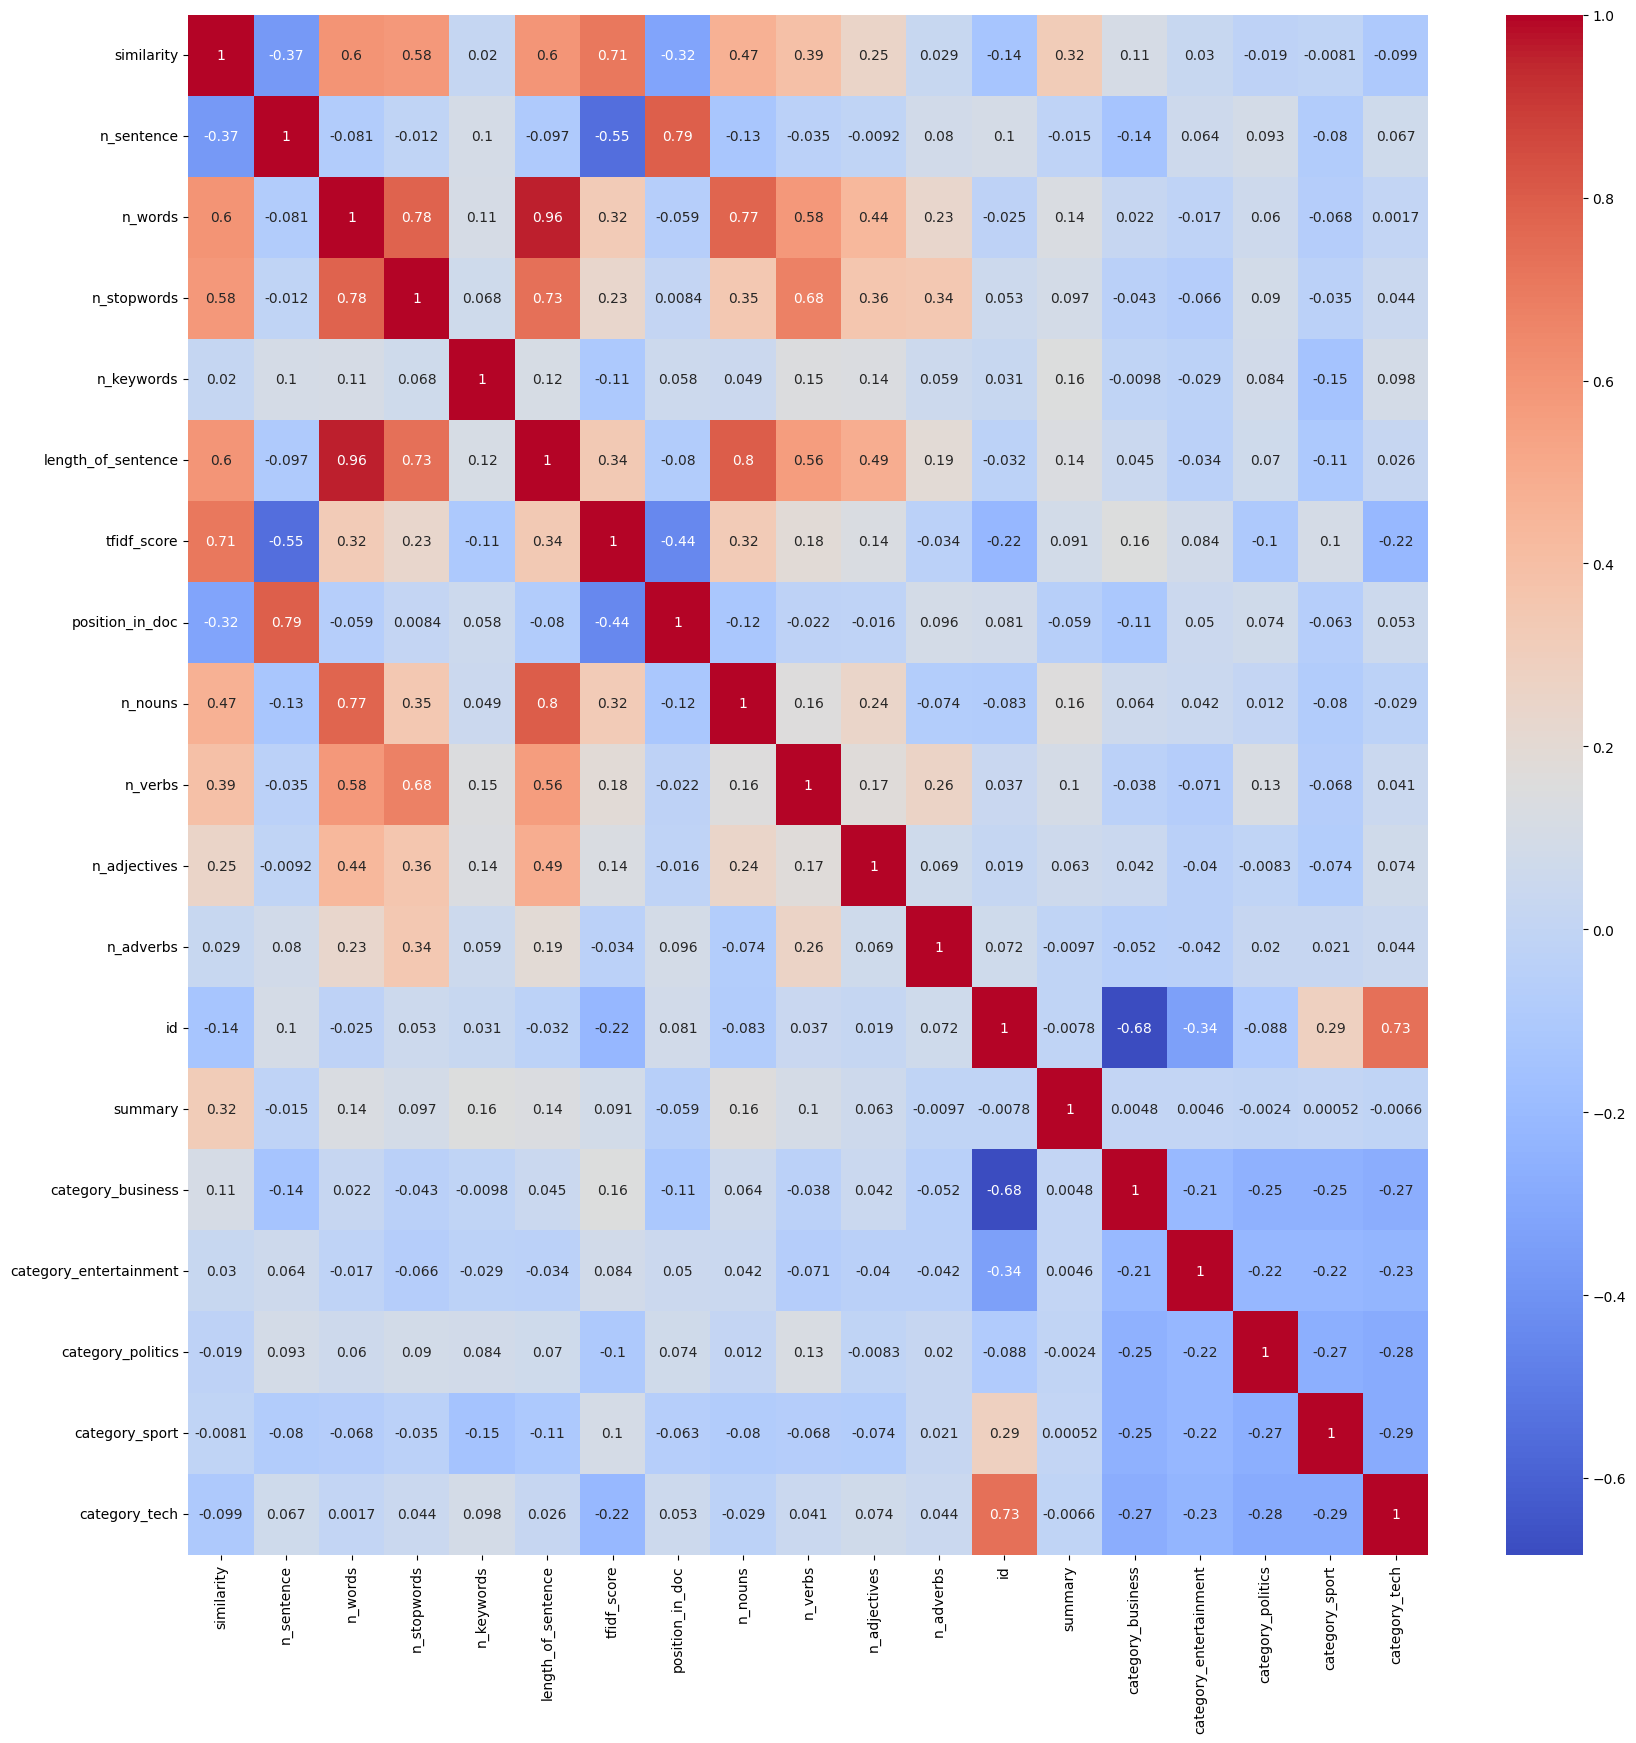

In [85]:
# Correlation matrix
correlation = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.show()

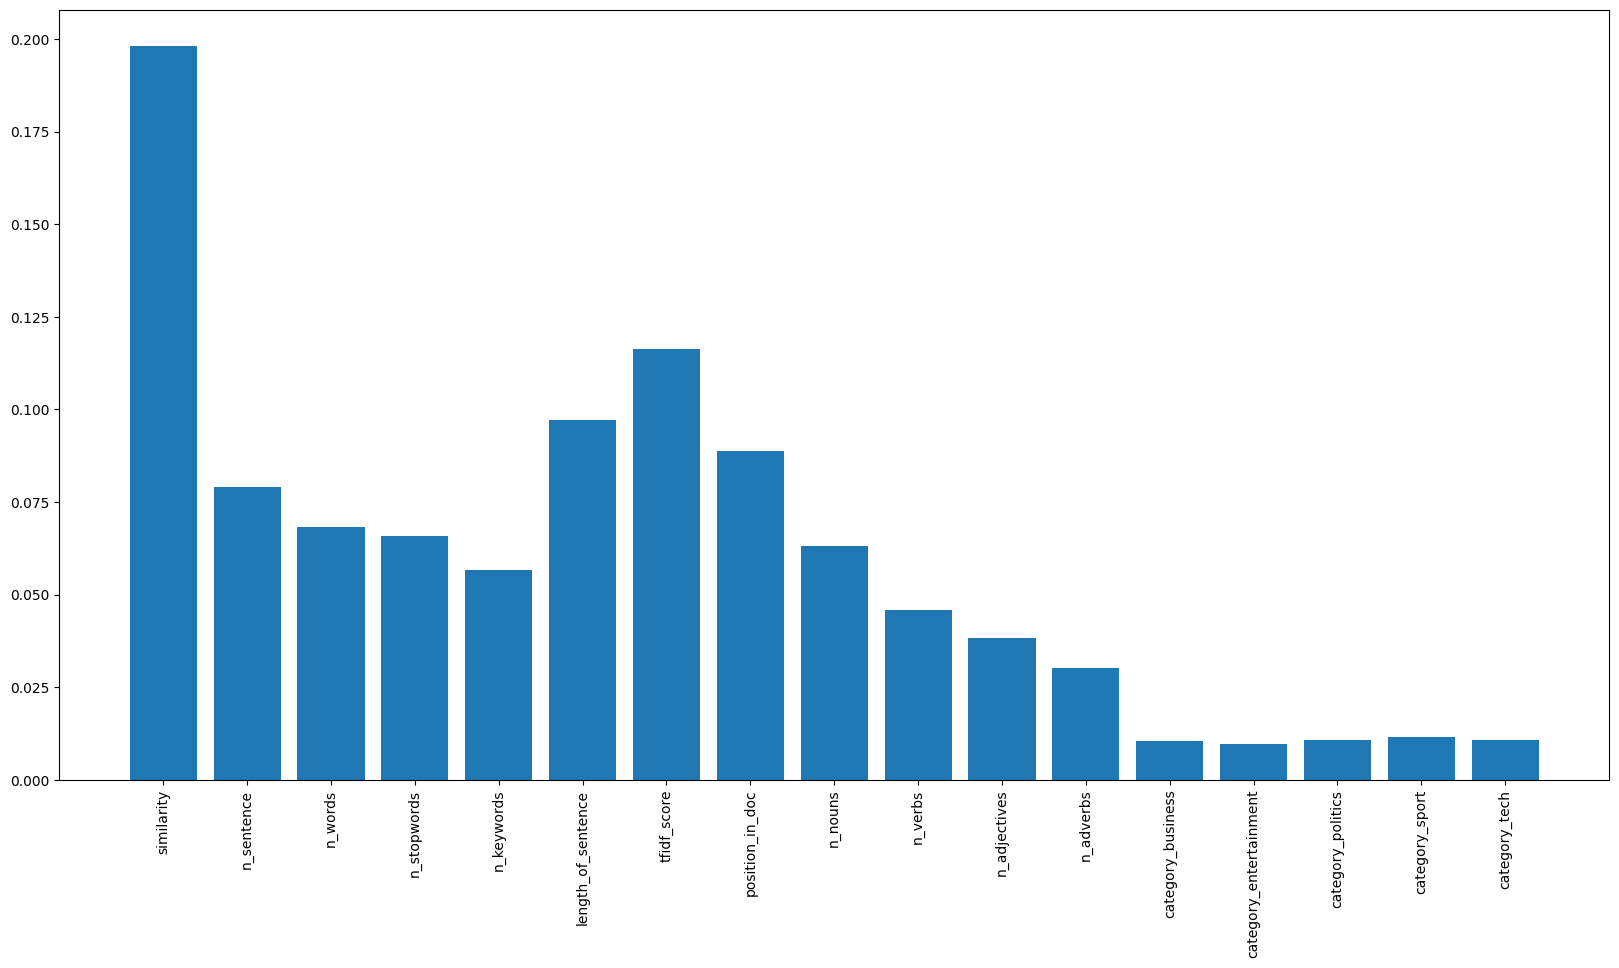

In [86]:
# Feature importance using the model

model = models["RandomForest"]

# take the feature importance
importances = model.feature_importances_

# plot
plt.figure(figsize=(20, 10))
plt.bar(X.columns, importances)
plt.xticks(rotation=90)
plt.show()

Looking at this correlation matrix we can see that there are some features that are highly correlated. We will remove them and see if the model improves.

- n_words 
- length_of_sentence
- of course the id
- categories can be removed too
  

In [ ]:
# import shap

# # Create the explainer
# explainer = shap.TreeExplainer(models["RandomForest"])

# # Calculate the shap values
# shap_values = explainer.shap_values(X_test)

# # Plot the shap values
# shap.summary_plot(shap_values, X_test, plot_type="bar")

# THIS IS TAKING INFINITE AMOUNT OF TIME

d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The above comment is to evaluate features importance using Shapley values. 
The problem here is computationally difficult, so it was taking too long to run. To avoid stressing locally our machines, it was executed on a 
[Kaggle notebook]( https://www.kaggle.com/code/danieleavolio/shap-ipr/edit ) . It took ~1:15h to run. The resulting graph can be seen here. 

In [173]:
# Redo the split
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for category, data in categories.items():
    X_train_category, X_test_category, y_train_category, y_test_category = train_test_split(
        data.drop(columns=["id", "category_business", "category_entertainment", "category_politics", "category_sport", "category_tech", "length_of_sentence", "summary"]), data["summary"], test_size=0.2
    )

    X_train = pd.concat([X_train, X_train_category])
    X_test = pd.concat([X_test, X_test_category])
    y_train = pd.concat([y_train, y_train_category])
    y_test = pd.concat([y_test, y_test_category])


# Train each model
for name, model in models.items():
    print(f"Training {name} model")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Confusion matrix: \n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification report: \n {classification_report(y_test, y_pred)}")
    print("\n")

Training RandomForest model


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7371725220330798
Confusion matrix: 
 [[3996  866]
 [1311 2110]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.75      0.82      0.79      4862
         1.0       0.71      0.62      0.66      3421

    accuracy                           0.74      8283
   macro avg       0.73      0.72      0.72      8283
weighted avg       0.73      0.74      0.73      8283



Training GradientBoosting model


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.708076783773995
Confusion matrix: 
 [[3913  949]
 [1469 1952]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76      4862
         1.0       0.67      0.57      0.62      3421

    accuracy                           0.71      8283
   macro avg       0.70      0.69      0.69      8283
weighted avg       0.70      0.71      0.70      8283



Training GaussianNB model
Accuracy: 0.6207895689967403
Confusion matrix: 
 [[3021 1841]
 [1300 2121]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.70      0.62      0.66      4862
         1.0       0.54      0.62      0.57      3421

    accuracy                           0.62      8283
   macro avg       0.62      0.62      0.62      8283
weighted avg       0.63      0.62      0.62      8283



Training KNeighbors model


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.6101653990100205
Confusion matrix: 
 [[3424 1438]
 [1791 1630]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.66      0.70      0.68      4862
         1.0       0.53      0.48      0.50      3421

    accuracy                           0.61      8283
   macro avg       0.59      0.59      0.59      8283
weighted avg       0.60      0.61      0.61      8283



Training MLP model


d:\Lovaion\University\2nd Year\Erasmus\Information Processing and Retrieval\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6952794881081734
Confusion matrix: 
 [[3166 1696]
 [ 828 2593]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.79      0.65      0.71      4862
         1.0       0.60      0.76      0.67      3421

    accuracy                           0.70      8283
   macro avg       0.70      0.70      0.69      8283
weighted avg       0.71      0.70      0.70      8283





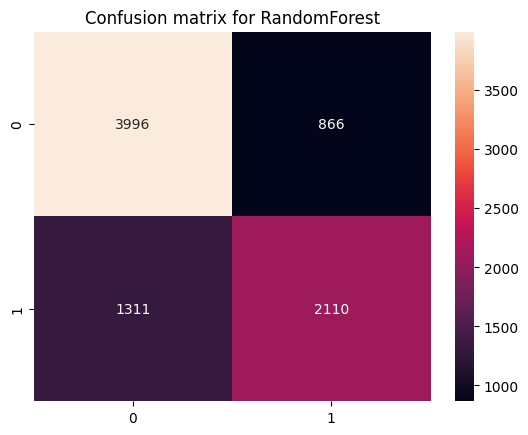

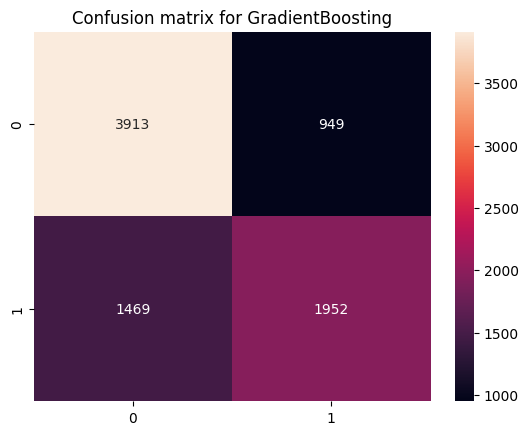

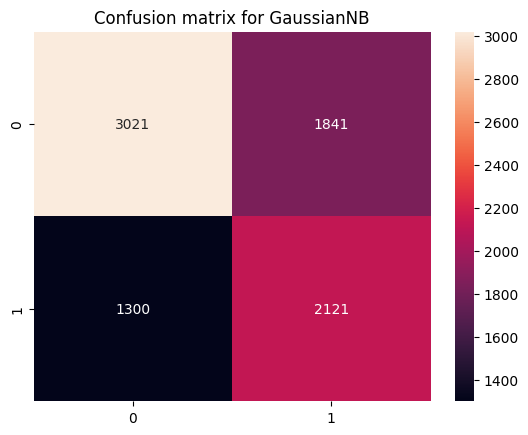

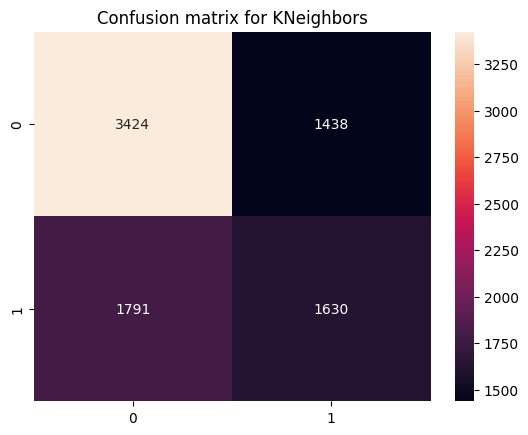

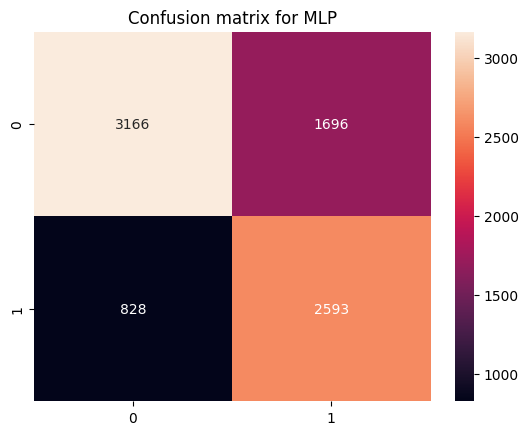

In [174]:
# For each model, plot the confusion matrix in a grid
for name, model in models.items():
    plt.figure()
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion matrix for {name}")
    plt.show()

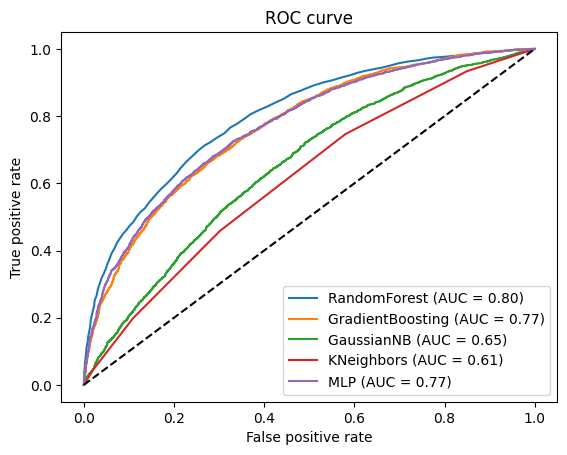

In [92]:
# roc curve
from sklearn.metrics import roc_curve, roc_auc_score

# plot each roc curve in a single plot with different colors
plt.figure()
for name, model in models.items():
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:0.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()



*C) Ranking extension*

This should be the step we did before, to add more features to the dataset.

In [ ]:
#code here

*C2) Summarization*

In [186]:
def preprocess_text(doc:str, columns:list, **kwargs):
    sentences = nltk.sent_tokenize(doc)
    features = []
    for sentence in sentences:
        feature = feature_extraction(sentence, doc)
        features.append(feature)

    
    df = pd.DataFrame(features, columns=columns)
    df = df.drop(columns=["category", "length_of_sentence"])
    
    return df
    

def summarization_2(doc:any, M:any, p:int=-1, l:int=-1, columns:list=None, **kwargs):
    pdf = preprocess_text(doc, columns)

    sentences = nltk.sent_tokenize(doc)
    
    summary = []

    char_left = l
    num_sent = p

    predicted = []

    predicted = M.predict(pdf)

    print(predicted)   
    for t in range(len(predicted)):
        if predicted[t] == 1 and (num_sent == -1 or len(summary) < num_sent):
            if(char_left == -1 or len(sentences[t]) <= char_left):
                summary.append(sentences[t])

    return summary

In [188]:
# get the document from the test set
doc_index = 1 
doc = documents[doc_index]

columns = [
        "similarity",
        "n_sentence",
        "n_words",
        "n_stopwords",
        "n_keywords",
        "length_of_sentence",
        "tfidf_score",
        "position_in_doc",
        "category",
        "n_nouns",
        "n_verbs",
        "n_adjectives",
        "n_adverbs",
]

summarization_2(doc, models["RandomForest"], p=3, l=100, columns=columns)

[1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.]


['In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday.',
 'Market concerns about the deficit has hit the greenback in recent months.']

*D) Evaluation*

In [ ]:
#code, statistics and/or charts here

<H2>Question materials (optional)</H2>

<H3>Part I: clustering</H3>

**(1)** Do clustering-guided summarization alters the behavior and efficacy of the IR system?

In [ ]:
#code, statistics and/or charts here

**(2)** How sentence representations, clustering choices, and rank criteria impact summarization?

In [ ]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>